In [416]:
import os, cv2, random
import numpy as np
import pandas as pd
import csv

import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib notebook

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D 

from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import Xception # TensorFlow ONLY
from keras.applications import VGG16
from keras.applications import VGG19
from keras.applications import imagenet_utils

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

In [461]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

ROWS = 224
COLS = 224
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


random.shuffle(train_dogs)
random.shuffle(train_cats)
# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:500] + train_cats[:500]
#test_images = test_images[:25]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = []
    
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data.append(image[:,:,::-1])
        if i%500 == 0: print('Processed {} of {}'.format(i, count))
    
    return np.asarray(data, dtype=np.float32)


In [ ]:
train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

In [486]:
labels = [int('dog' in i) for i in train_images]
n_classes = len(np.unique(labels))
category_labels = keras.utils.to_categorical(labels, n_classes)

In [193]:
train[0].max()

222.0

<IPython.core.display.Javascript object>


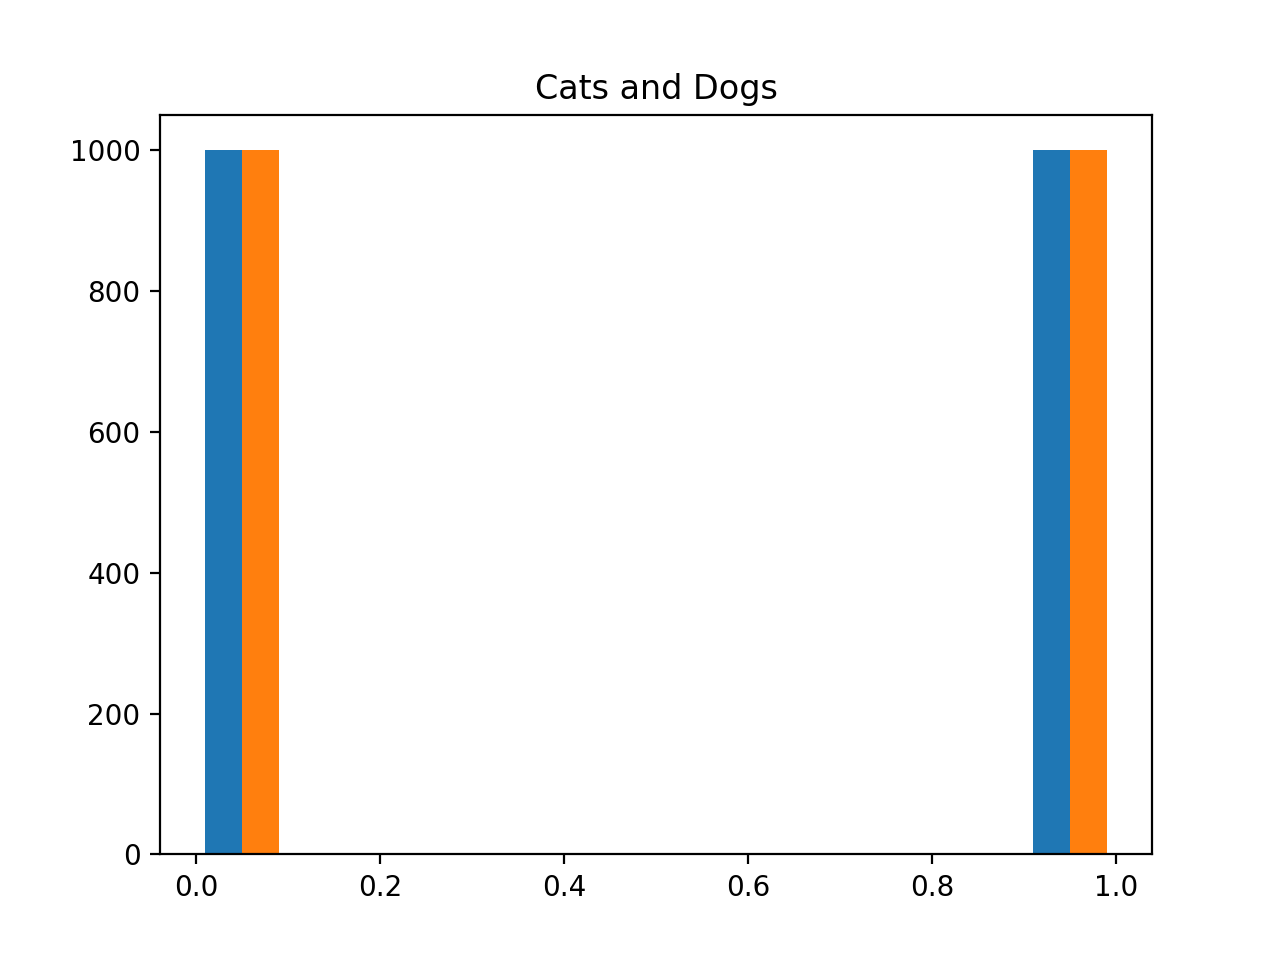

In [153]:
plt.figure()
plt.hist(category_labels)
plt.title('Cats and Dogs')

In [462]:
train_arr = [process_image(load_img(path, target_size=(ROWS, COLS))) for path in train_images]
labels = [int('dog' in i) for i in train_images]

In [436]:
test_arr = [process_image(load_img(path, target_size=(ROWS, COLS))) for path in test_images]

In [445]:
test_ids = [int(img.split('/').pop()[:-4]) for img in test_images]

In [512]:
max_images = len(test_arr)

file = open('submission_vgg19.csv', 'a')
file.write('id,label\n')

pred_labels = []
for i, img in enumerate(test_arr[:max_images]):
    label = predict(img, debug=False)
    pred_labels.append(label)
    if i%1000 == 0: print('Processed {} of {}'.format(i, max_images))
    file.write('{0},{1}\n'.format(test_ids[i], label))
file.close()

Processed 0 of 12500
Processed 1000 of 12500
Processed 2000 of 12500
Processed 3000 of 12500
Processed 4000 of 12500
Processed 5000 of 12500
Processed 6000 of 12500
Processed 7000 of 12500
Processed 8000 of 12500
Processed 9000 of 12500
Processed 10000 of 12500
Processed 11000 of 12500
Processed 12000 of 12500


In [498]:
start = 550
max_images = 50

pred_labels = []
for i, img in enumerate(train_arr[start:start+max_images]):
    label = predict(img, debug=False)
    pred_labels.append(label)
    if i%50 == 0: print('Processed {} of {}'.format(i, max_images))


Processed 0 of 50


In [508]:
pred_labels = np.asarray(pred_labels)
np.where(pred_labels > 0.5)

(array([ 4, 12, 20, 22, 35, 38, 47]),)

In [511]:

#wrong_images = np.asarray(train_images)[:max_images][np.asarray(labels[:max_images]) != np.asarray(pred_labels[:max_images])]
#train_images[start+20], train_images[start:start+max_images], labels[start:start+max_images]

In [451]:
model = VGG19(weights="imagenet")

574078976/574710816 [============================>.] - ETA: 0s    

<IPython.core.display.Javascript object>


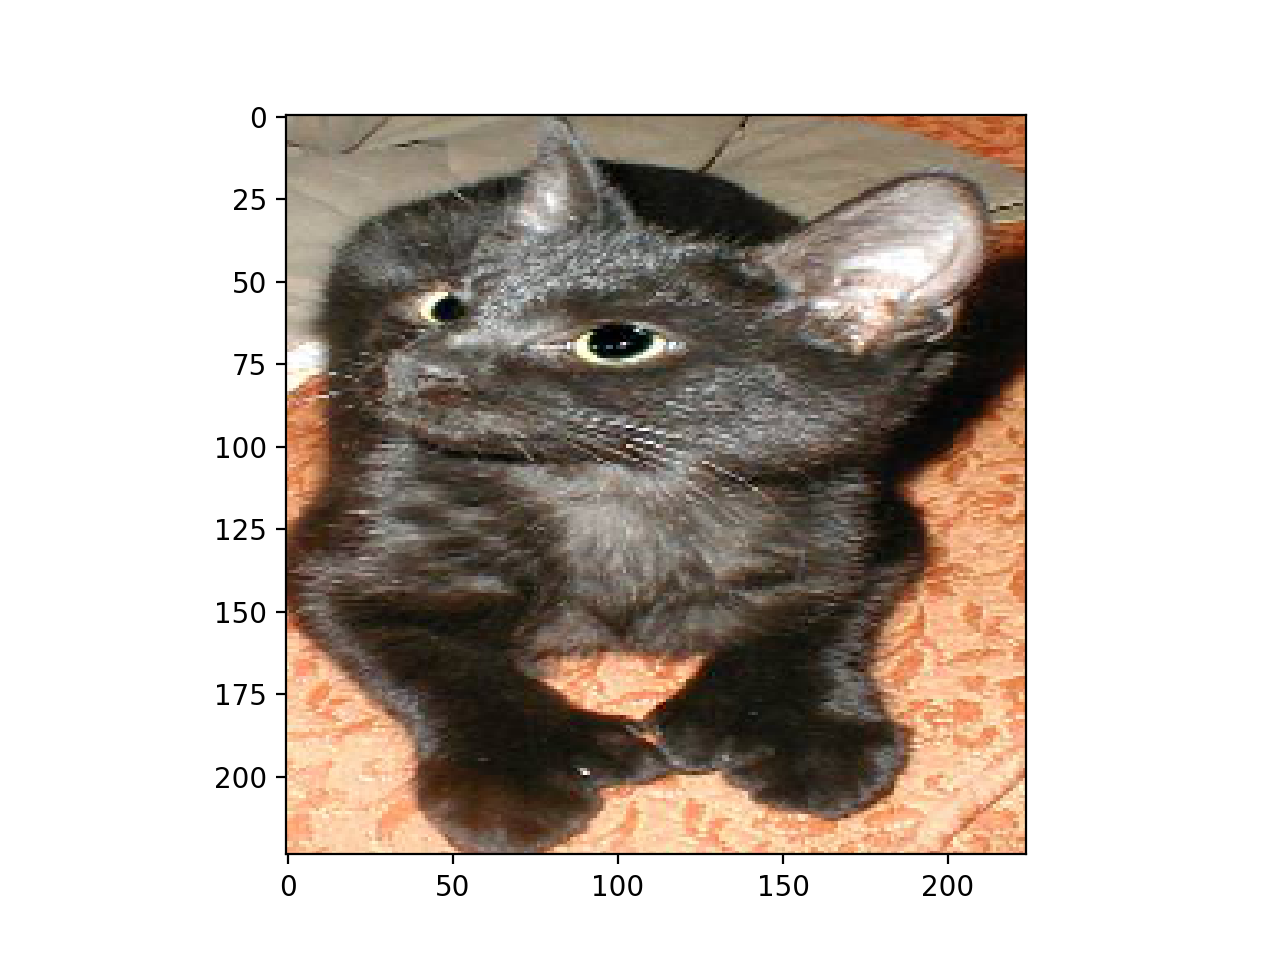

1. schipperke: 0.65 watchdog guard dog  n02104365
2. Egyptian_cat: -0.07 egyptian cat  n02124075
3. Scotch_terrier: 0.03 hunting dog  n02097298
4. groenendael: 0.03 belgian sheepdog belgian shepherd  n02105056
5. space_heater: -0.01 physical entity  n04265275
dog 0.821435320657 watchdog guard dog  egyptian cat  hunting dog  belgian sheepdog belgian shepherd  physical entity  


0.82143532065674663

In [510]:
import requests
image_path = 'data/train/cat.774.jpg'
image_path = 'data/train/dog.11465.jpg'
image_path = 'data/train/cat.11954.jpg'
def process_image(image):
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)
    return image
    
def classify(score, text):
    if score < 0.5:
        return 'cat'
    elif score > 0.5:
        return 'dog'
    else:
        return text
    
def resole_cat_dog(text):
    if 'toy' in text:
        return -0.01
    elif 'cat' in text or 'ferret' in text or 'monkey' in text:
        return -1
    elif 'dog' in text or 'canine' in text or 'wolf' in text:
        return 1
    elif 'entity' in text:
        return -0.25
    else: 
        return 0
    
def lookup_wordnetID(wid):
    text = wordnet_mapper[wid]
    score = resole_cat_dog(text)
    if score != 0:
        return score, text

    if wid in mappings:
        arr = mappings[wid]
        for wid in arr:
            return lookup_wordnetID(wid)
    else:
        return (0, text)
    
    return score, text
    
def predict(image, debug=False):
    preds = model.predict(image)
    P = imagenet_utils.decode_predictions(preds)
    
    score = 0
    texts = ''

    for (i, (imagenetID, label, prob)) in enumerate(P[0]):
        val, text = lookup_wordnetID(imagenetID)
        score += (val * prob)
        texts += text + ' '
        
        if debug:
            print("{}. {}: {:.2f} {} {}".format(i + 1, label, val * prob, text, imagenetID))
            
    norm_score = score/2 + 0.5
    if debug:
        print(classify(norm_score, texts), norm_score, texts)

    return norm_score


def get_wordnet_map():
    with open('/Users/alyssa/Documents/stuff/fastai/wordnet_mapper.csv', 'r') as csvfile:
        mapper = {row[0]: row[1] for row in csv.reader(csvfile, delimiter=',')}
    return mapper


plot = True

image = load_img(image_path, target_size=(ROWS, COLS))
if plot:
    plt.figure()
    plt.imshow(image)
pimage = process_image(image)   
predict(pimage, plot)

In [417]:
wordnet_mapper = get_wordnet_map()

In [229]:
from collections import defaultdict

mappings_url = 'http://www.image-net.org/archive/wordnet.is_a.txt'
mappings = defaultdict(list)
wordnetids = set()
r = requests.get(mappings_url, stream=True)

for line in r.iter_lines():
    parent, child = line.decode('utf-8').split(' ')
    mappings[child].append(parent)
    wordnetids.add(parent)
    wordnetids.add(child)

In [418]:
import functools

wordnet_id2words_baseurl = 'http://www.image-net.org/api/text/wordnet.synset.getwords?wnid='
id2words = {}

@functools.lru_cache(maxsize=1024)
def get_words(wid):
    req = requests.get(wordnet_id2words_baseurl + wid)
    text = ' '.join(req.text.strip().split())
    
    score = resole_cat_dog(text)
    if score != 0:
        return score, text

    if wid in mappings:
        arr = mappings[wid]
        for wid in arr:
            return get_words(wid)
    else:
        return (0, text)
    

In [386]:
from nltk.corpus import wordnet
    
@functools.lru_cache(maxsize=1024)
def lookup_wid(wid, is_synset=False):
    synset = wid if is_synset else wordnet.synset_from_pos_and_offset('n', int(wid[1:]))
    text = ' '.join(synset.lemma_names())
    score = resole_cat_dog(text)
    
    if score != 0:
        return score, text
    
    # Keep looking up the tree
    texts = ''
    parents = synset.hypernyms()
    for x in parents:
        return lookup_wid(x, True)

    return 0, text

In [302]:
get_words.cache_info()

CacheInfo(hits=7654, misses=712, maxsize=1024, currsize=712)

<IPython.core.display.Javascript object>


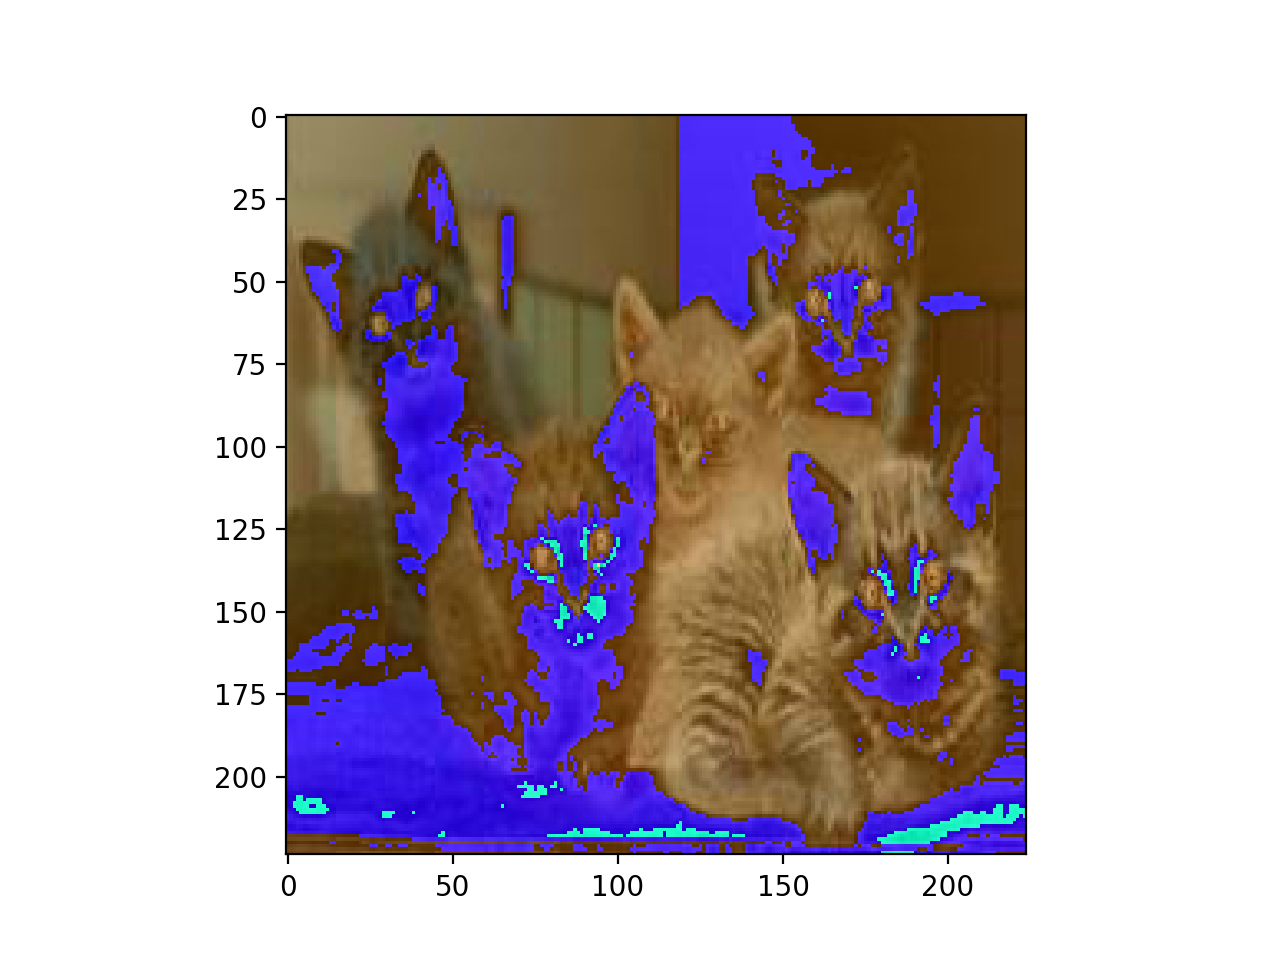

In [198]:
plt.figure()
plt.imshow(train[0])

In [95]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(ROWS, COLS, CHANNELS)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Reduce every 2x2 square into one value
model.add(Dropout(0.25))
model.add(Flatten()) # Convert the multi-dimensional space into 1D vector
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               7372928   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [96]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
model.fit(train, category_labels, batch_size=16, epochs=20, verbose=1, validation_split=0.2)

Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 41s - loss: 0.8744 - acc: 0.4850 - val_loss: 0.6933 - val_acc: 0.4800